In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [2]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [3]:
train_ds, val_ds = random_split(dataset,[50000,10000])
len(train_ds),len(val_ds)

(50000, 10000)

In [4]:
batch_sz=128
train_loader = DataLoader(train_ds,batch_sz,shuffle=True,num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds,batch_sz*2,shuffle=True,num_workers=4, pin_memory=True)




images.shape: torch.Size([128, 1, 28, 28])


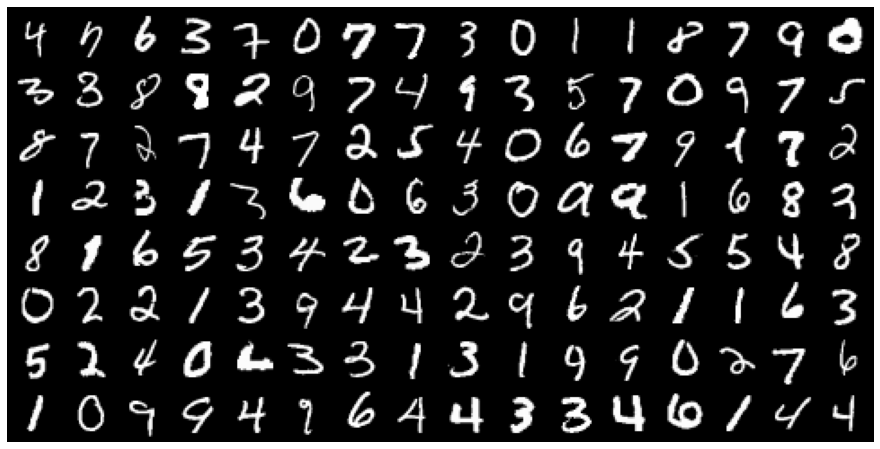

In [5]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

# Model

In [6]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [7]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [8]:
input_size = 784
hidden_size = 32
num_classes = 10

In [9]:
model = MnistModel(input_size,hidden_size,out_size=num_classes)

In [10]:
# print parameteres shape
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [11]:
for imgs, labels in train_loader:
    outputs = model(imgs)
    loss = F.cross_entropy(outputs,labels)
    print(loss.item())
    break
outputs.shape,outputs[:2].data

2.306518793106079


(torch.Size([128, 10]),
 tensor([[-0.0770, -0.0666, -0.0653, -0.1014, -0.1511,  0.0693,  0.0551, -0.0195,
          -0.2112, -0.1323],
         [-0.0935, -0.1945,  0.0737, -0.0478, -0.0505,  0.0569, -0.1987,  0.0238,
          -0.1478, -0.2671]]))

# Using a GPU

In [12]:
torch.cuda.is_available()
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
def to_device(data,device):
    '''move tensors to chosen device'''
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

In [15]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


In [16]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [18]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([9, 8, 2, 6, 0, 7, 4, 1, 3, 8, 2, 8, 6, 7, 3, 0, 2, 8, 0, 1, 2, 2, 6, 7,
        9, 6, 1, 4, 7, 2, 9, 5, 8, 9, 8, 5, 6, 9, 8, 0, 5, 1, 4, 3, 9, 6, 7, 4,
        2, 5, 7, 9, 1, 6, 4, 8, 3, 6, 0, 7, 8, 7, 5, 2, 9, 8, 6, 0, 6, 8, 3, 0,
        6, 5, 9, 9, 6, 1, 7, 3, 8, 1, 0, 5, 4, 6, 2, 3, 5, 4, 3, 3, 0, 2, 7, 5,
        8, 0, 6, 1, 7, 2, 4, 7, 4, 2, 4, 4, 7, 7, 2, 1, 2, 6, 2, 1, 1, 4, 4, 5,
        2, 0, 1, 6, 2, 2, 2, 7, 0, 9, 3, 4, 6, 0, 6, 4, 3, 4, 9, 6, 0, 7, 6, 2,
        7, 1, 4, 0, 7, 7, 6, 1, 3, 5, 8, 4, 1, 8, 2, 8, 4, 1, 1, 9, 1, 9, 8, 0,
        0, 7, 8, 1, 0, 9, 0, 7, 3, 7, 8, 5, 5, 5, 0, 2, 1, 1, 4, 4, 0, 2, 5, 7,
        3, 1, 2, 9, 4, 8, 0, 6, 9, 2, 8, 5, 1, 2, 9, 2, 9, 1, 0, 8, 3, 7, 0, 0,
        4, 1, 9, 5, 3, 1, 8, 1, 4, 2, 3, 2, 7, 7, 3, 9, 7, 5, 8, 0, 7, 3, 3, 1,
        4, 1, 8, 0, 8, 1, 2, 7, 0, 8, 3, 8, 8, 7, 0, 0], device='cuda:0')


In [19]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [21]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.08251953125, 'val_loss': 2.318066358566284}]

In [22]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2113, val_acc: 0.9375
Epoch [1], val_loss: 0.1600, val_acc: 0.9504
Epoch [2], val_loss: 0.1516, val_acc: 0.9520
Epoch [3], val_loss: 0.1271, val_acc: 0.9607
Epoch [4], val_loss: 0.1186, val_acc: 0.9636


In [24]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1000, val_acc: 0.9695
Epoch [1], val_loss: 0.0981, val_acc: 0.9684
Epoch [2], val_loss: 0.1028, val_acc: 0.9686
Epoch [3], val_loss: 0.1028, val_acc: 0.9670
Epoch [4], val_loss: 0.1000, val_acc: 0.9681


In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

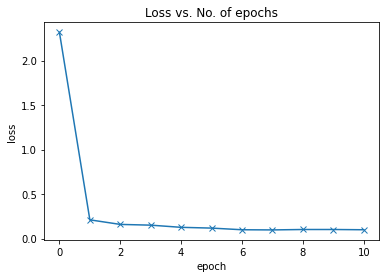

In [26]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

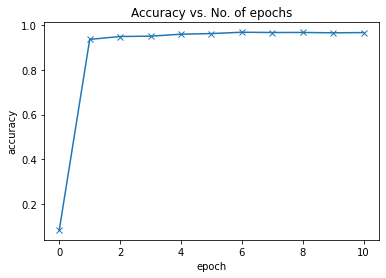

In [27]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');